In [ ]:
from IPython.display import clear_output 

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/MLProject'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/MLProject


In [4]:
import os
import json
import numpy
import matplotlib.pyplot as plt
import skimage
from skimage import io
from shapely.geometry import Polygon
import shapely
#from rtree import index
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import matplotlib.pyplot as plt

In [5]:
!pip install q keras==2.2.4

     |████████████████████████████████| 317kB 7.3MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [1]:
import keras

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
keras.__version__

'2.2.4'

In [3]:
!pip install tensorflow==1.14.0

In [1]:
import tensorflow

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
tensorflow.__version__

'1.14.0'

In [2]:
!pip install tensorflow-gpu==1.14.0

     |████████████████████████████████| 377.0MB 47kB/s 


In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Found GPU at: /device:GPU:0


**Code for splitting the images into smaller images**

In [2]:
def overflow(img_dimension, box_dimension, overlap):
    # Returns number of passes box must make in one direction to cover the image
    adjusted = box_dimension - overlap
    return (img_dimension//adjusted + int(bool(img_dimension % adjusted)))

def region2polygon(region):  # get the polygon that is wrapped in a region object
    x_and_y_unparsed = region["shape_attributes"]
    all_points_x= x_and_y_unparsed["all_points_x"]
    all_points_y= x_and_y_unparsed["all_points_y"]
    polygon = Polygon(list(zip(all_points_x, all_points_y)))
    polygon.class_str = region["region_attributes"]["class"]
    return polygon

# build an rtree over all ploygons (their bounding boxes) in an image
def rtree_over_pgons(polygons): # [x1, y1, x2, y2]
    idx = index.Index()
    for pos, polygon in enumerate(polygons):
        idx.insert(pos, polygon.bounds)
    return idx

def rect2polygon(x1, y1, x2, y2):
    p1 = (x1, y1)
    p2 = (x1, y2)
    p3 = (x2, y2)
    p4 = (x2, y1)
    return Polygon([p1, p2, p3, p4])

def coord_adjust(polygon_list, positions, x1, y1):
    adjusted_polygons = []
    for pos in positions:
        polygon = polygon_list[pos]
        new_polygon = shapely.affinity.translate(polygon, xoff = -x1, yoff = -y1)
        new_polygon.class_str = polygon.class_str
        adjusted_polygons.append(new_polygon)
    return adjusted_polygons

def region_maker(polygons):
    regions_dicts = []
    for polygon in polygons:
        xs, ys = polygon.exterior.coords.xy
        # Convert the tuples to lists and the floats to ints
        xs = [int(j) for j in xs]
        ys = [int(j) for j in ys]
        regions_dicts.append({
            "shape_attributes": {
                "name": "polygon",
                "all_points_x": xs,
                "all_points_y": ys
            },
            "region_attributes": {
                "class": polygon.class_str
            }
        })

    return regions_dicts

class AnnotatedImages:
    # member variables:
    # 1. img_dir # path of the image folder
    # 2. annotation_dict # a dictionary of annotations in the format of the JSON file

    def __init__(self, img_dir, annotation_file_path):
        self.img_dir = img_dir
        with open(annotation_file_path) as json_file:
            self.annotation_dict = json.load(json_file)

    def get_path(self, img_file):
        if os.name == 'nt':
            return self.img_dir + '\\' + img_file
        return self.img_dir + '/' + img_file

    def img_size(self, img_file):  # return the JSON key of VIA (= filename + file_size)
        size = os.stat(self.get_path(img_file)).st_size
        return size

    def img_key(self, img_file):  # return the JSON key of VIA (= filename + file_size)
        size = self.img_size(img_file)
        dict_key = img_file + str(size)
        return dict_key

    # get the polygons (wrapped by region-object list) of an image
    def get_region_list(self, dict_key):
        regions = self.annotation_dict[dict_key]["regions"]
        return regions

    # get the polygons (wrapped by region-object list) of an image
    def get_polygon_list(self, img_file):
        dict_key = self.img_key(img_file)
        regions = self.get_region_list(dict_key)
        #print(regions)
        polygons = []
        for region in regions:
            polygon = region2polygon(region)
            polygons.append(polygon)
        return polygons

    def generate(self, bbox_shape, overlap, output_image_directory, output_annotation_file_path):
        # slide a box of the shape: bbox_shape = (width, height)

        # create image output folder
        self.new_dir = os.path.join(os.getcwd(), output_image_directory)
        if not os.path.exists(self.new_dir):
            os.makedirs(self.new_dir)

        # main sliding logic
        box_w, box_h = bbox_shape
        assert(min(box_w, box_h) > overlap)
        annotation_dict = {}
        for img_file in os.listdir(self.img_dir):
            if img_file.endswith('.jpg'):  # if current file is an .jpg image
                # get ploygons of the img_file
                polygons = self.get_polygon_list(img_file)
                pgon_rtree = rtree_over_pgons(polygons)
                # load the current image
                img = io.imread(self.get_path(img_file), pilmode="RGB")
                # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! debug BEGIN: to plot the image along with all polygons
                """
                plt.figure(figsize=(10, 10))
                io.imshow(img)
                for polygon in polygons:
                    x, y = polygon.exterior.xy
                    plt.plot(x, y)
                plt.show()
                # """
                # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! debug END
                img_h, img_w, _ = img.shape
                # if bbox can fit inside the image
                accumulator_x, accumulator_y = 0, 0
                for i in range(overflow(img_w, box_w, overlap)):
                    for j in range(overflow(img_h, box_h, overlap)):
                        # slide
                        y_end = accumulator_y+box_h
                        if y_end > img_h:
                            y_end = img_h
                        x_end = accumulator_x+box_w
                        if x_end > img_w:
                            x_end = img_w
                        # get ploygons inside the sliding box
                        query_box = (accumulator_x, accumulator_y, x_end, y_end) # [x1, y1, x2, y2]
                        pgon_positions = list(pgon_rtree.intersection(query_box))
                        # refinement: filtering polygons that are not totally inside the sliding box
                        sliding_box = rect2polygon(*query_box) # get the polygon object for the image, to be used for rtree refinement
                        refined_positions = []
                        for pos in pgon_positions:
                            polygon = polygons[pos]
                            if sliding_box.contains(polygon):
                                refined_positions.append(pos)

                        # print('len(refined_positions) =', len(refined_positions)) #!!!!!!!!!!!!!!!!!!!!!
                        
                        adjusted_polygons = coord_adjust(polygons, refined_positions, accumulator_x, accumulator_y)
                        
                        if len(adjusted_polygons) == 0: # there's no polygon in the box
                            accumulator_y += box_h - overlap
                            continue
                        
                        # get the image
                        new_img = img[accumulator_y:y_end,
                                      accumulator_x:x_end]
                        # save the image
                        img_file_noJPG = img_file[:-4]
                        new_img_name = f"{img_file_noJPG}_{i}_{j}.jpg"
                        new_img_path = os.path.join(output_image_directory, new_img_name)
                        io.imsave(new_img_path, new_img)
                        new_img_file_size = os.stat(new_img_path).st_size
                        
                        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! debug BEGIN: to plot the image along with all polygons
                        '''
                        plt.figure(figsize=(10, 10))
                        io.imshow(new_img)
                        
                        #polyons inside
                        for polygon in adjusted_polygons:
                            x, y = polygon.exterior.xy
                            plt.plot(x, y)
                        plt.show()
                        # '''
                        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! debug END
                        
                        # return  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! debug: stop after just one slide

                        # save regions of the new image into annotation_dict
                        annotation_dict[new_img_name + str(new_img_file_size)] = {
                            "filename": new_img_name,
                            "size": new_img_file_size,
                            "regions": region_maker(adjusted_polygons),
                            "file_attributes": {}
                        }
                        
                        accumulator_y += box_h - overlap
                    # move y to beginning, move x to next row
                    accumulator_x += box_w - overlap
                    accumulator_y = 0

                # return  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!! debug: stop after just one slide
                    
        ## print(annotation_dict)
        with open(output_annotation_file_path, 'w') as annot_outfile:
            json.dump(annotation_dict, annot_outfile, indent=4)

In [ ]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

**Splitting the images in the dataset into smaller images for better training**

In [ ]:
an = AnnotatedImages(r"HQ_Annotations\HQ_Images",
                     r"HQ_Annotations\HQ_annotations.json")
an.generate((1000, 1000), 200, r"annotated", r"annotated\new_annotation.json")

C:\Users\skond\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: annotated\img_1623_5_0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\skond\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: annotated\img_227_5_0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\skond\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: annotated\img_2337_3_1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
C:\Users\skond\Anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: annotated\img_2687_4_0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


**Defining the path**

In [5]:
# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn.model import MaskRCNN
 
# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
 
# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


**Configuration of the model and Custom dorne image function to load images and load masks**<br>
total 8000 images in dataset splitting them into 7000 fro training and 1000 for testing.

In [6]:
############################################################
#  Configurations
############################################################
 
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
 
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # Number of classes (including background)
    NUM_CLASSES = 1 + 5  # Background + classes
    BACKBONE = "resnet50"
    
    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.6
    
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 512
    
    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.6
 
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 300
    TRAIN_ROIS_PER_IMAGE = 512
    
    # Max number of final detections
    DETECTION_MAX_INSTANCES = 100
 
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.6
    DETECTION_NMS_THRESHOLD = 0.4
 
 
############################################################
#  Dataset
############################################################
 
class CustomDataset(utils.Dataset):
 
    def load_custom(self, dataset_dir, is_train=True):
        """Load a subset of the bottle dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("class", 1, "Head")
        self.add_class("class", 2, "Thread")
        self.add_class("class", 3, "Nut")
        self.add_class("class", 4, "Pin")
        self.add_class("class", 5, "Washer")
 
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "new_annotation.json")))
        #print(annotations1)
        #annotations =[]
        #annotations = annotations.append(annotations1.values())
        annotations = list(annotations1.values()) # don't need the dict keys
 
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
 
        # Add images
        z=0
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['class'] for s in a['regions']]
            #print("objects:",objects)
            name_dict = {"Head": 1,"Thread": 2,"Nut": 3,"Pin": 4,"Washer": 5}
            # key = tuple(name_dict)
            #num_ids = []
            #for n in objects:
                #if n['class']=='Head':
            		   # num_ids.append(1)
            	 # elif n['class']=='Thread':
            	  	 # num_ids.append(2)
                #elif n['class']=='Nut':
            	     # num_ids.append(3)
               # elif n['class']=='Pin':
            	     # num_ids.append(4)
                #elif n['class']=='Washer':
            	     # num_ids.append(5)
            #num_ids = [int(n['class']) for a in objects]
            num_ids = [name_dict[a] for a in objects]
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            #print("numids",num_ids)
            # skip all images after 150 if we are building the train set
            z = z+1
            if is_train and z >= 7000:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and z < 7000:
                continue
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
 
            self.add_image(
                "class",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids)
            
        
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "class":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        #print(info["polygons"])
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
        #print("mask:",mask)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids
 
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "class":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

functions to create train and test set and training the model

In [7]:
def traincreate(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom('annotated', is_train=True)
    dataset_train.prepare()
 
    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom('annotated', is_train=False)
    dataset_val.prepare()
    return dataset_train,dataset_val
    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
def train(dataset_train,dataset_val):
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')
    print("Training network layers")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=20,
                #augmentation=augmentation,
                layers='4+')
    print("Training network All")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE/10,
                epochs=30,
                #augmentation=augmentation,
                layers='all')

**For colour splash**

In [8]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash
 
def detect_and_color_splash(model, img):
        # Run model detection and generate the color splash effect
        print("Running on {}".format(img))
        # Read image
        image = skimage.io.imread(img)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        #file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        #skimage.io.imsave(file_name, splash)
        #io.imshow(file_name)
        #print("Saved to ", file_name)
        display_images([splash], cols=1)

**Preparing data for training**

In [9]:
#preparing data for training where 'x' is train set and 'y' is test set
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')
weights_path = COCO_WEIGHTS_PATH
model.load_weights(weights_path, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"])
x,y=traincreate(model)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


**Training the model**

In [14]:
#training the model where 'x' is train set and 'y' is test set
train(x,y)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: ./object20201206T1918/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_b

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker



Epoch 1/10
300/300 [==============================] - 318s 1s/step - loss: 1.8471 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.5488 - mrcnn_class_loss: 0.1505 - mrcnn_bbox_loss: 0.5314 - mrcnn_mask_loss: 0.5532 - val_loss: 1.7117 - val_rpn_class_loss: 0.0340 - val_rpn_bbox_loss: 0.5046 - val_mrcnn_class_loss: 0.1084 - val_mrcnn_bbox_loss: 0.5205 - val_mrcnn_mask_loss: 0.5441
Epoch 2/10
300/300 [==============================] - 260s 865ms/step - loss: 1.5328 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.4973 - mrcnn_class_loss: 0.1475 - mrcnn_bbox_loss: 0.3839 - mrcnn_mask_loss: 0.4579 - val_loss: 1.6574 - val_rpn_class_loss: 0.0628 - val_rpn_bbox_loss: 0.5583 - val_mrcnn_class_loss: 0.1284 - val_mrcnn_bbox_loss: 0.4532 - val_mrcnn_mask_loss: 0.4546
Epoch 3/10
300/300 [==============================] - 264s 880ms/step - loss: 1.4446 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.4406 - mrcnn_class_loss: 0.1521 - mrcnn_bbox_loss: 0.3697 - mrcnn_mask_loss: 0.4452 - val_loss: 1.4382 - val_rpn

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 11/20
300/300 [==============================] - 345s 1s/step - loss: 1.3746 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4123 - mrcnn_class_loss: 0.1426 - mrcnn_bbox_loss: 0.3545 - mrcnn_mask_loss: 0.4317 - val_loss: 1.3612 - val_rpn_class_loss: 0.0204 - val_rpn_bbox_loss: 0.3879 - val_mrcnn_class_loss: 0.1074 - val_mrcnn_bbox_loss: 0.4046 - val_mrcnn_mask_loss: 0.4409
Epoch 12/20
300/300 [==============================] - 287s 956ms/step - loss: 1.3591 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.4213 - mrcnn_class_loss: 0.1303 - mrcnn_bbox_loss: 0.3473 - mrcnn_mask_loss: 0.4280 - val_loss: 1.4852 - val_rpn_class_loss: 0.0518 - val_rpn_bbox_loss: 0.5175 - val_mrcnn_class_loss: 0.1158 - val_mrcnn_bbox_loss: 0.3660 - val_mrcnn_mask_loss: 0.4341
Epoch 13/20
300/300 [==============================] - 288s 961ms/step - loss: 1.3117 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.4054 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.4214 - val_loss: 1.3798 - val_rp

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple worker

Epoch 21/30
300/300 [==============================] - 388s 1s/step - loss: 1.1772 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.3470 - mrcnn_class_loss: 0.1252 - mrcnn_bbox_loss: 0.2799 - mrcnn_mask_loss: 0.3990 - val_loss: 1.1735 - val_rpn_class_loss: 0.0150 - val_rpn_bbox_loss: 0.3377 - val_mrcnn_class_loss: 0.0836 - val_mrcnn_bbox_loss: 0.3319 - val_mrcnn_mask_loss: 0.4054
Epoch 22/30
300/300 [==============================] - 321s 1s/step - loss: 1.1529 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.3440 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.2742 - mrcnn_mask_loss: 0.3972 - val_loss: 1.4279 - val_rpn_class_loss: 0.0448 - val_rpn_bbox_loss: 0.4722 - val_mrcnn_class_loss: 0.1185 - val_mrcnn_bbox_loss: 0.3620 - val_mrcnn_mask_loss: 0.4304
Epoch 23/30
300/300 [==============================] - 323s 1s/step - loss: 1.1336 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.3339 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.3928 - val_loss: 1.2481 - val_rpn_clas

In [63]:
#Inference configuration for model

class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.6
DETECTION_NMS_THRESHOLD        0.4
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [64]:
#getting ax for images for plotting
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
     
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [69]:
#loading the model with the least loss
MODEL_DIR='object20201206T1918'
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,config=config) 

In [70]:
#model 29 with least loss
path='object20201206T1918/mask_rcnn_object_0029.h5'
model.load_weights(path, by_name=True)

**Model Testing**

Test set mAP

In [67]:
def evaluate_model(dataset, model, cfg):
  APs = []
  for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, cfg, image_id, use_mini_mask=False)

        # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
	# calculate the mean AP across all images
  mAP = np.mean(APs)
  return mAP

In [68]:
#train_mAP = evaluate_model(x, model, config)
#print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
from mrcnn.model import load_image_gt
test_mAP = evaluate_model(y, model, config)
print("Test mAP: %.3f" % test_mAP)

Test mAP: 0.323


In [71]:
#creating list with image ids for testing on 10 images

list=[145,146,147,148,149,795,796,797,798,799]

image ID: class.img_677_1_0.jpg (145) annotated/img_677_1_0.jpg
gt_class_id              shape: (20,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (20, 4)               min:  181.00000  max: 1011.00000  int32
gt_mask                  shape: (1024, 1024, 20)      min:    0.00000  max:    1.00000  uint8
image ID: class.img_677_1_1.jpg (146) annotated/img_677_1_1.jpg
gt_class_id              shape: (10,)                 min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (10, 4)               min:   16.00000  max:  999.00000  int32
gt_mask                  shape: (1024, 1024, 10)      min:    0.00000  max:    1.00000  uint8
image ID: class.img_677_2_0.jpg (147) annotated/img_677_2_0.jpg
gt_class_id              shape: (19,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (19, 4)               min:  117.00000  max:  982.00000  int32
gt_mask                  shape: (1024, 1024, 19)      mi

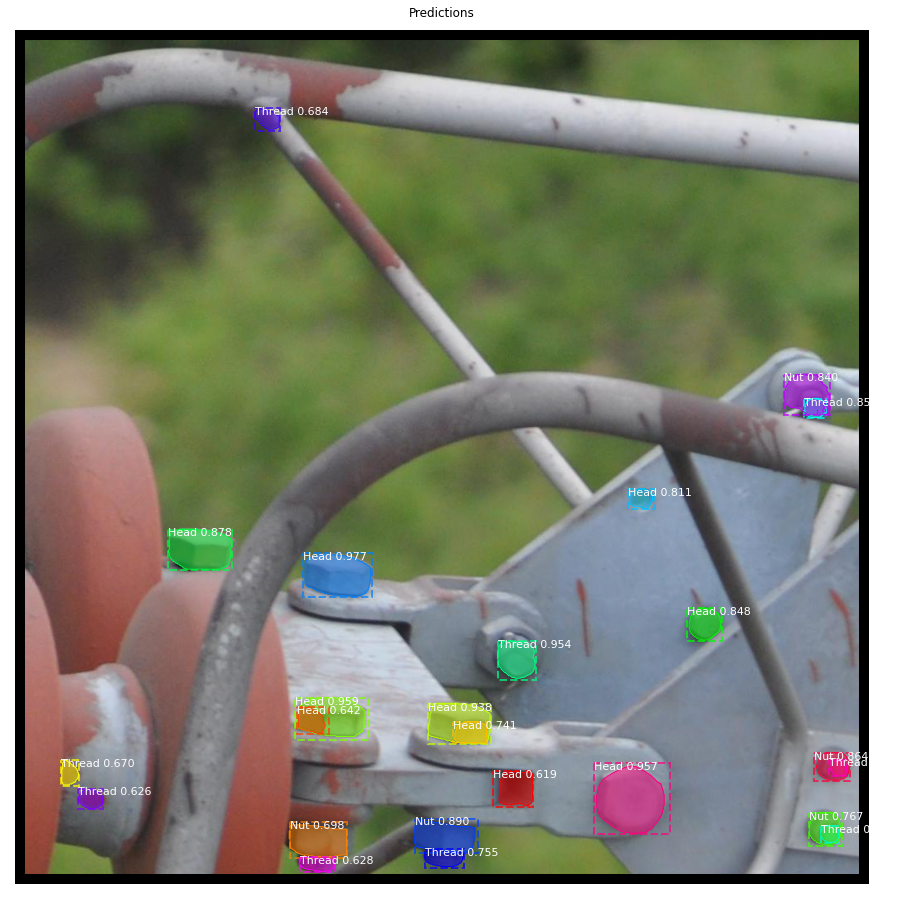

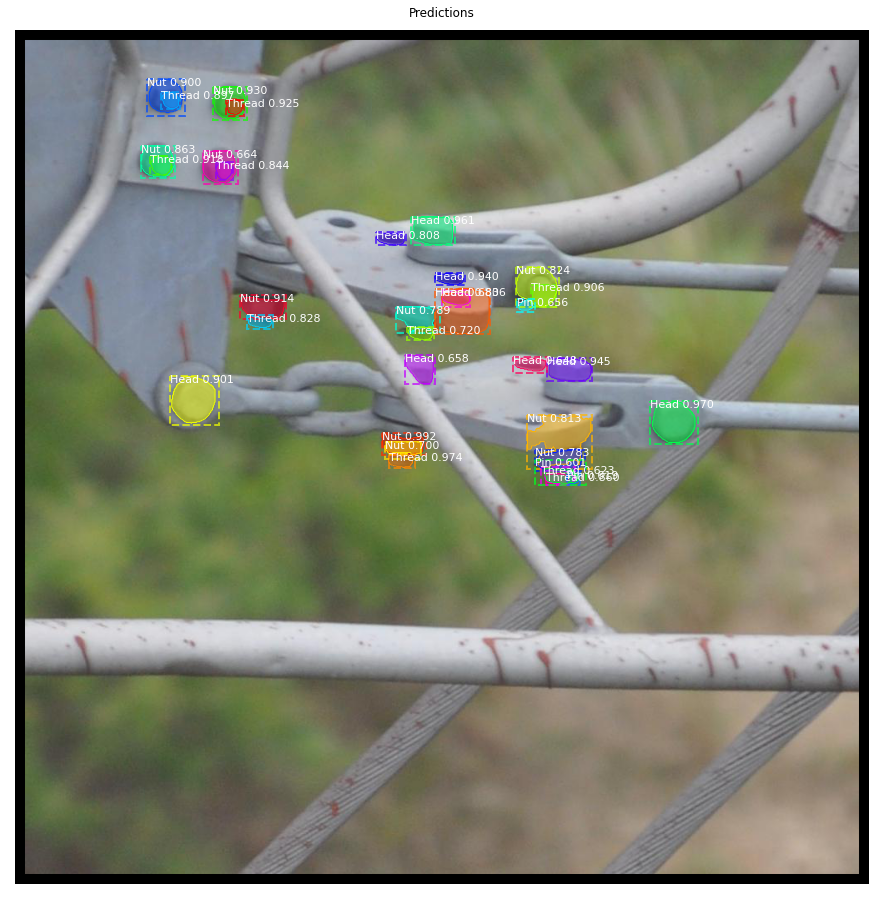

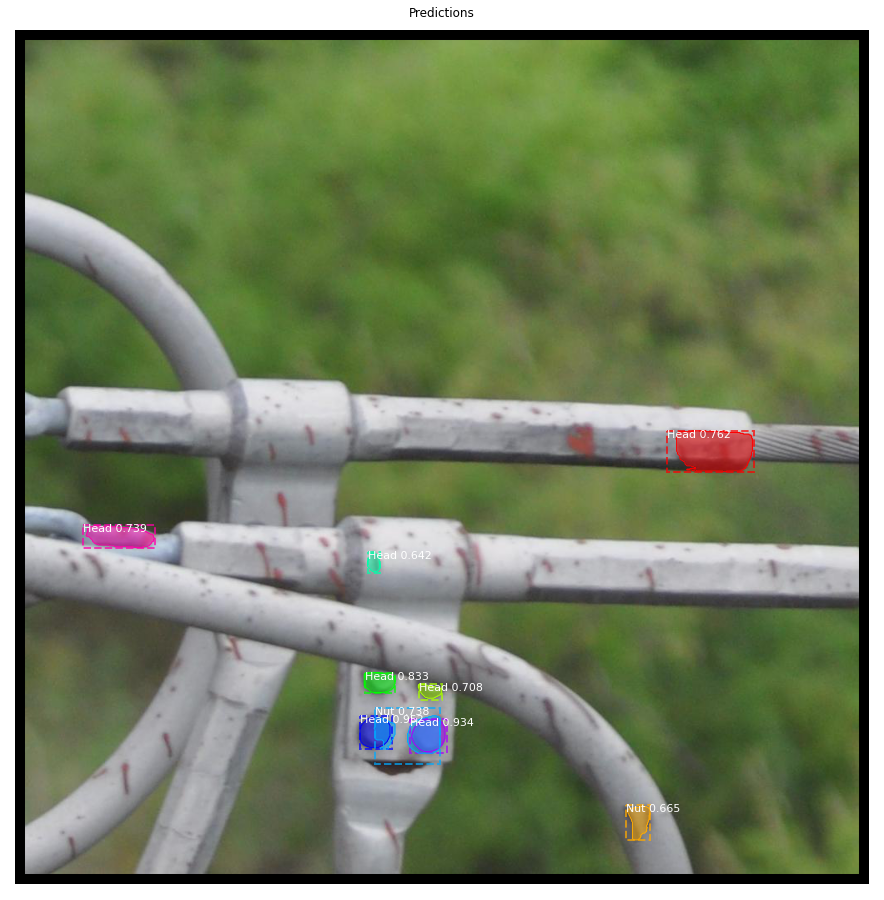

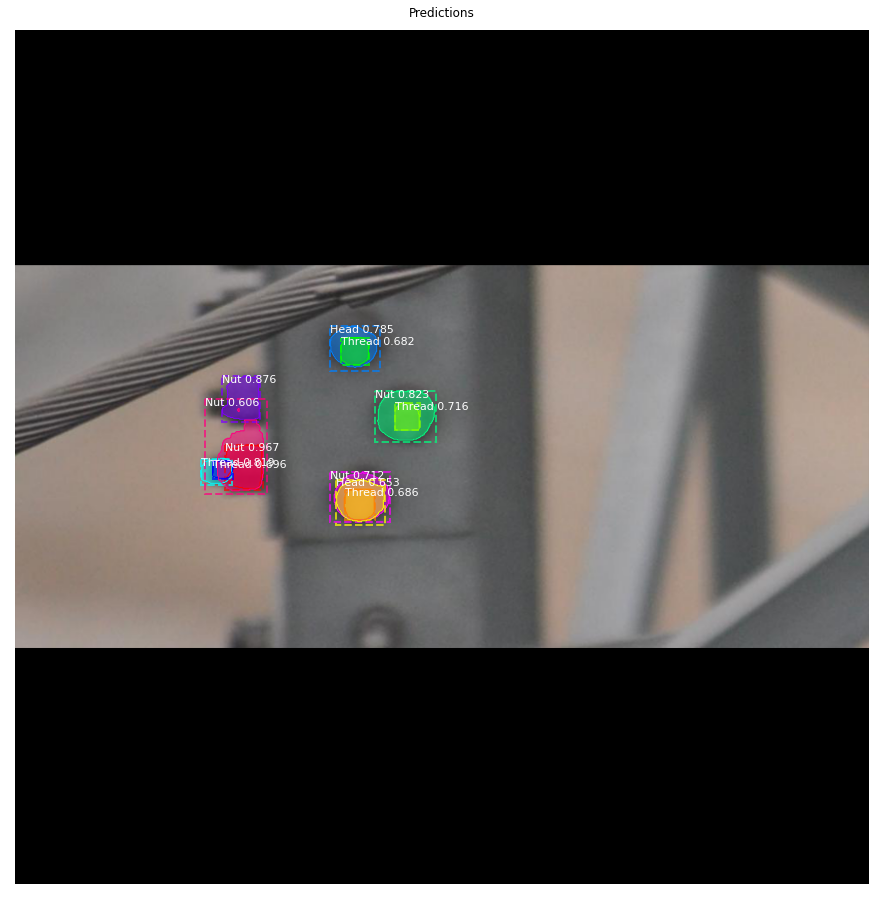

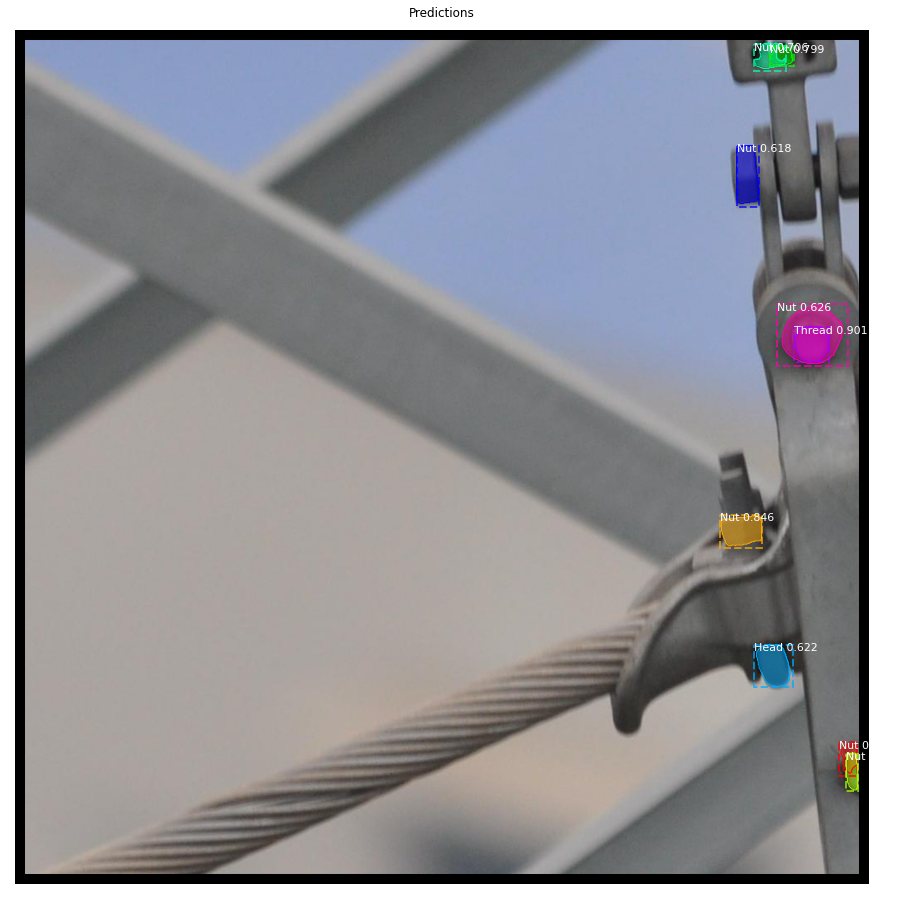

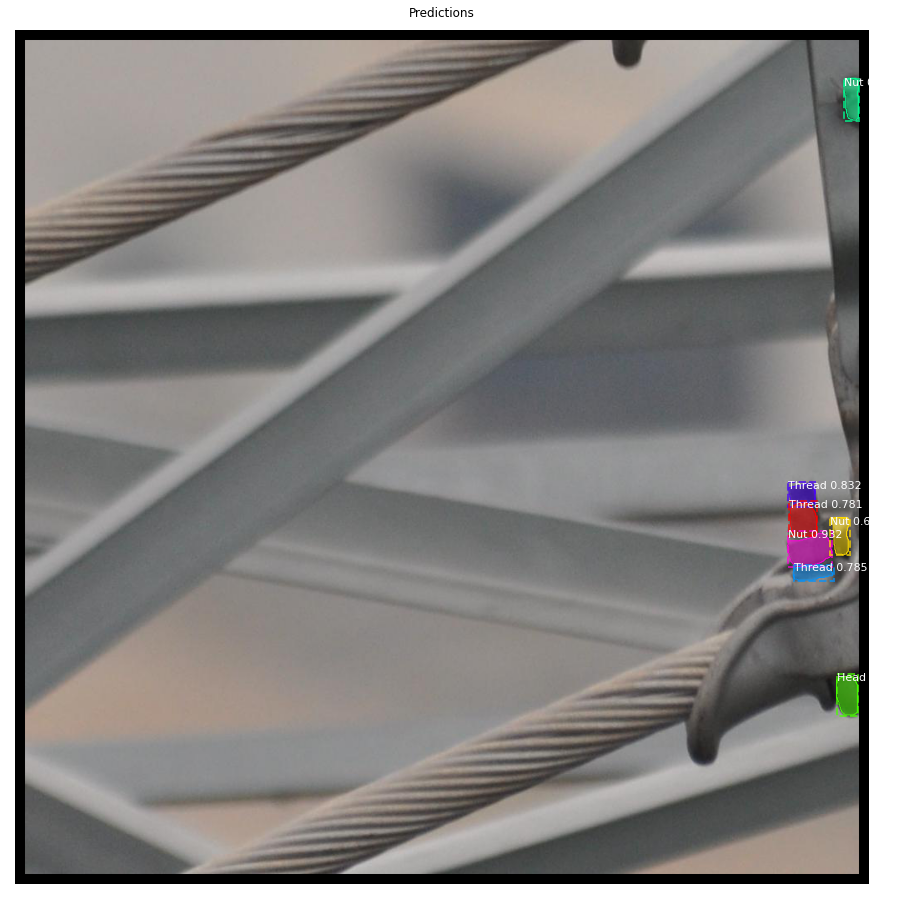

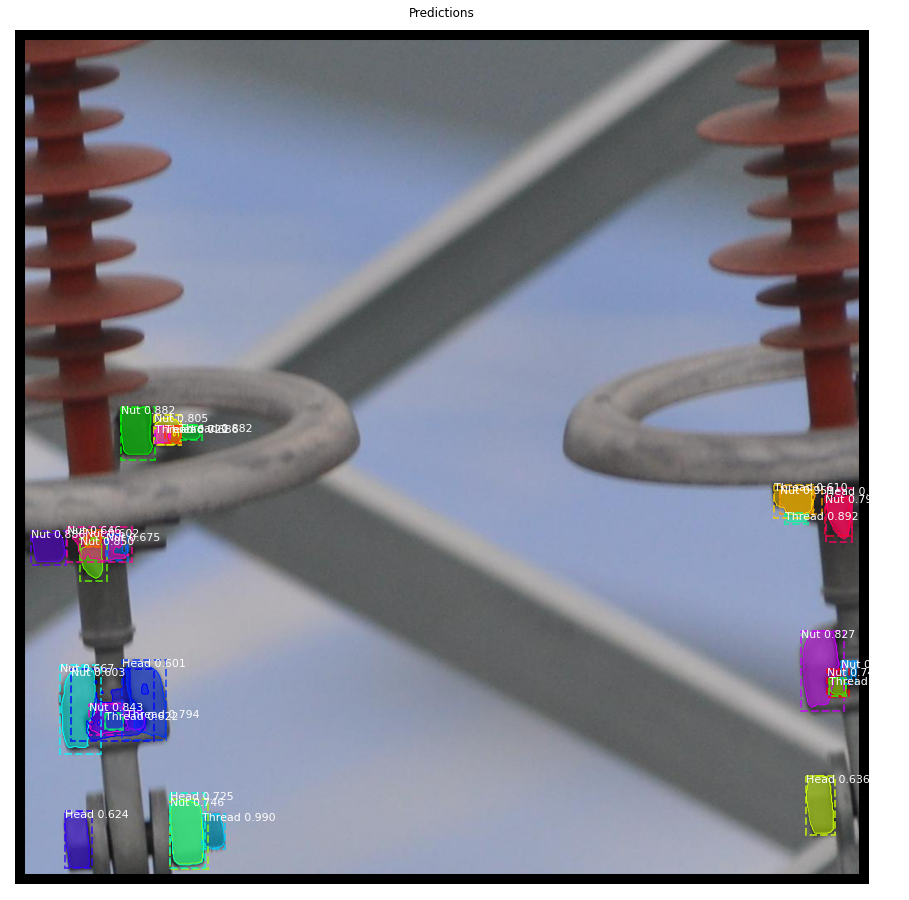

In [72]:
#visualizing results
from mrcnn import visualize
from mrcnn.model import log
resultlist=[]
mAP=[]
for i in list:
        image_id = i
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(y, config, image_id, use_mini_mask=False)
        info = y.image_info[image_id]
        print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       y.image_reference(image_id)))

        # Run object detection
        results = model.detect([image], verbose=0)

        # Display results
        ax = get_ax(1)
        r = results[0]
        resultlist.append(r)
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            y.class_names, r['scores'], ax=ax,
                            title="Predictions")
        AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
        mAP.append(AP)
        log("gt_class_id", gt_class_id)
        log("gt_bbox", gt_bbox)
        log("gt_mask", gt_mask)

**10 Test images MEAN AVERAGE PRECISION (mAP)**

In [73]:
print("mAP",np.mean(mAP))

mAP 0.6691121296355673


In [74]:
pickle_file = "predictions.pkl"

In [75]:
#Pickle predictions
import pickle
with open(pickle_file, "wb") as file:
    pickle.dump(results, file)

In [76]:
#r = None
predictions = None

#Unpickle predictions
with open(pickle_file, "rb") as file:
    predictions = pickle.load(file)

Pickle object structure

In [77]:
image_id = 0 #Same image_id to see fair comparison with the groud truth above.

In [78]:
print(type(predictions))

<class 'list'>


In [79]:
prediction = predictions[image_id] #Same image_id to illustrate the prediction generated for the image visualized above.
print(f"Object type: {type(prediction)}")

Object type: <class 'dict'>


In [80]:
print(f"Dictionary keys: {prediction.keys()}")

Dictionary keys: dict_keys(['rois', 'class_ids', 'scores', 'masks'])


In [81]:
print(f"Rois: \n{prediction['rois']}")

Rois: 
[[138 225 182 253]
 [525 269 572 327]
 [427 934 456 966]
 [885 196 911 226]
 [498 265 541 316]
 [356 133 397 174]
 [864 183 916 239]
 [454 266 497 300]
 [580  45 620  92]
 [505 917 545 978]
 [734 261 781 315]
 [ 18 104  41 132]
 [121 185 206 229]
 [532  43 584  85]
 [ 15  86  48 125]
 [677 349 725 376]
 [456 930 509 973]
 [127 180 196 249]
 [663 498 726 539]
 [329 118 402 189]
 [115 186 203 227]
 [139  60 208  89]
 [136  63 209  91]
 [ 94 949 165 984]
 [467 921 538 977]]


(Rois) Regions of Interest are detection bounding boxes. <br>
Has the shape: [N, (y1, x1, y2, x2)] <br>
N is number of regions.<br>
x, y are the coordinates of the bounding box.<br>

In [82]:
print(f"Class IDs: \n{prediction['class_ids']}")

Class IDs: 
[2 3 2 2 3 2 3 2 3 3 1 3 3 3 3 1 2 2 1 3 1 1 3 1 3]


class_ids are unique IDs given to each class in the dataset. Defined in DroneConfig class. <br>
Has the shape: [N] <br>
N, is number of regions.<br>
Each ID is an integer.<br>

In [83]:
print(f"Scores: \n{prediction['scores']}")

Scores: 
[0.9912077  0.9766575  0.9684436  0.95589286 0.92472583 0.92214173
 0.9203482  0.9078301  0.9029129  0.8879488  0.79882413 0.78462523
 0.7550683  0.6997259  0.6909643  0.6808387  0.6657119  0.65355504
 0.6419788  0.64099956 0.63608944 0.611217   0.6077523  0.60735726
 0.60333115]


In [84]:
prediction['masks'].shape

(1024, 1024, 25)

In [85]:
print(f"Mask: \n{prediction['masks'][:1]}")

Mask: 
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]]


masks are binary masks.<br>
Has the shape: [H, W, N]<br>
H and W are height and weight of each image, set to 1024 in DroneConfig class.<br>
N is numner of regions.<br>

**Prediction on random image**

In [86]:
from mrcnn import visualize
import matplotlib.image as mpimg
from mrcnn.visualize import display_images
image1 = mpimg.imread('testimages/10.jpg')
    # Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)
 
    # Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],
                            y.class_names, r1['scores'], ax=ax,
                            title="Predictions1")

1
Processing 1 images
image                    shape: (1000, 1000, 3)       min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32
